# Evaluación Parcial N°3 - PARTE 2: TRANSFORMERS
# DUOC UC - Deep Learning (DLY0100)
# Estudiantes:
- Diego Velasquez
- Daniel Iturra
- Jonathan Huala
- Jorge Gonzalez
# Fecha: 02-07-2025

# Análisis de Negocio
**Objetivo del proyecto:**
El objetivo general del análisis es predecir si un cliente está interesado en comprar un seguro de vehículo, en base a distintas variables demográficas y de comportamiento. Esto le permitirá a la empresa dirigir mejor sus campañas y enfocar recursos en clientes con mayor probabilidad de conversión.

**Métricas clave:**
Dado que es un problema de clasificación binaria, las métricas clave que se utilizarán son:
| **Métrica**            | **Descripción**                                                                 |
|------------------------|----------------------------------------------------------------------------------|
| **Accuracy**           | Porcentaje de predicciones correctas. Útil si las clases están balanceadas.     |
| **Precision**          | Qué proporción de los positivos predichos son verdaderos positivos.             |
| **Recall**             | Qué proporción de los positivos reales fueron correctamente identificados.      |
| **F1-score**           | Media armónica entre Precision y Recall. Muy útil en clases desbalanceadas.     |
| **Matriz de confusión**| Muestra los verdaderos positivos, falsos positivos, falsos negativos y verdaderos negativos. |


## 1. Importación de Librerías y Configuración

In [1]:
# Importar las librerías necesarias

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Configurar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Verificar recursos disponibles (GPU, versión TensorFlow)

print("=== CONFIGURACIÓN INICIAL ===")
# Completar verificaciones
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"GPUs disponibles: {tf.config.list_physical_devices('GPU')}")

=== CONFIGURACIÓN INICIAL ===
Versión de TensorFlow: 2.19.0
GPUs disponibles: []


## 2. Carga y Exploración del Dataset

### 2.1 Análisis Exploratorio de Datos

=== CARGA DEL DATASET ===
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Forma del conjunto de entrenamiento: (2773,)
Forma del conjunto de prueba: (2963,)
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Análisis Exploratorio de Datos: Conjunto de Entrenamiento ---
Estadísticas de longitud de reseñas:
  Media: 68.59
  Mediana: 69.00
  Mínimo: 11
  Máximo: 99
  Desviación estándar: 18.46


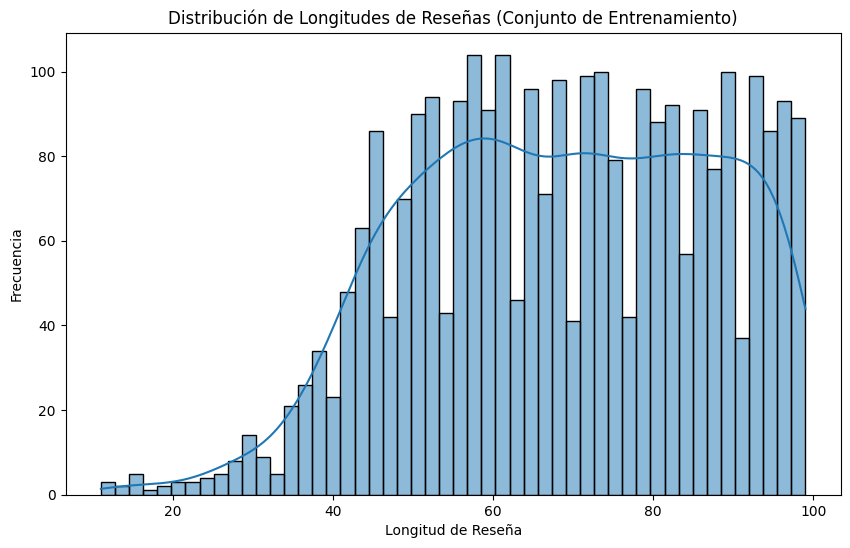


Distribución de Clases (Conjunto de Entrenamiento):
1    1537
0    1236
Name: count, dtype: int64


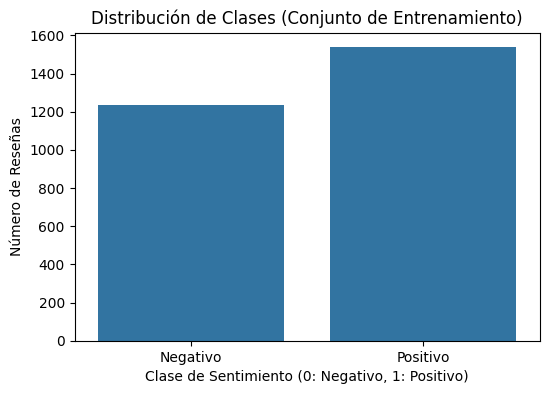


--- Análisis Exploratorio de Datos: Conjunto de Prueba ---
Estadísticas de longitud de reseñas:
  Media: 67.95
  Mediana: 68.00
  Mínimo: 7
  Máximo: 99
  Desviación estándar: 18.80


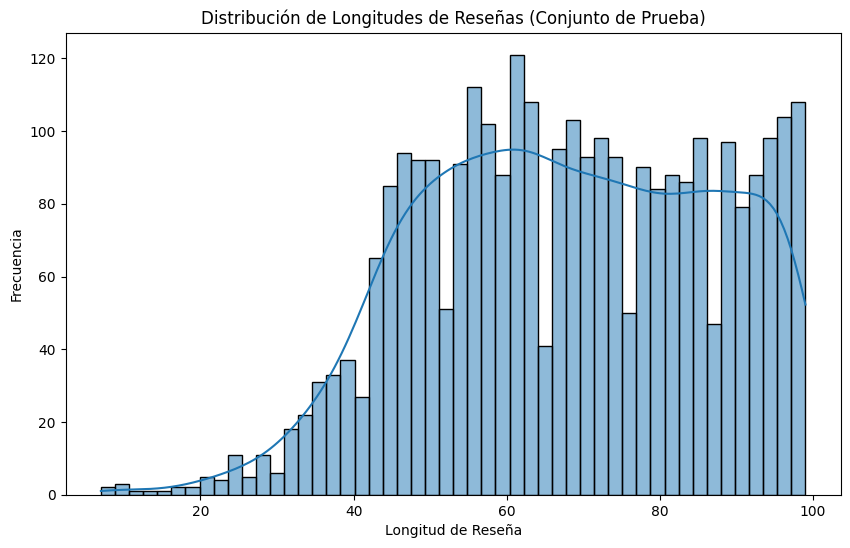


Distribución de Clases (Conjunto de Prueba):
1    1604
0    1359
Name: count, dtype: int64


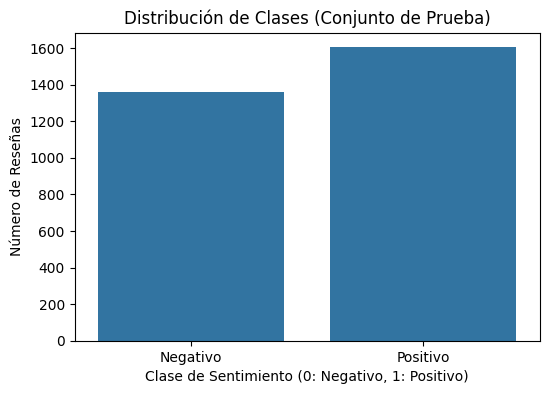


=== EJEMPLOS DE RESEÑAS DECODIFICADAS ===

Reseña 1 (Clase: 0):
<START> begins better than it ends funny that the russian submarine crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br

Reseña 2 (Clase: 0):
<START> when i rented this movie i had very low expectations but when i saw it i realized that the movie was less a lot less than what i expected the actors were bad the doctor's wife was one of the worst the story was so stupid it could work for a disney movie except for the murders but this one is not a comedy it is a laughable masterpiece of stupidity the title is well chosen except for one thing they could add stupid movie after dead husbands i give it 0 and a half out of 5

Reseña 3 (Clase: 1):
<START> the original demille movie was made in 1938 with <UNK> march a very good film indeed hollywood's love of remakes brings us a fairly interesting movie starring 

In [2]:
print("=== CARGA DEL DATASET ===")
# Cargar el dataset IMDB para clasificación de sentimientos
# Definir parámetros del dataset

VOCAB_SIZE = 10000
MAX_LEN = 100

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=VOCAB_SIZE, maxlen=MAX_LEN
)


# Mostrar información básica del dataset
print(f"Forma del conjunto de entrenamiento: {x_train.shape}")
print(f"Forma del conjunto de prueba: {x_test.shape}")

# Obtener diccionario de palabras y función de decodificación
word_index = tf.keras.datasets.imdb.get_word_index()
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


# Implementar función para analizar el dataset
def analyze_dataset(x_data, y_data, title="Dataset"):
    """
    Analyzes the distribution of review lengths and sentiment classes in the dataset.
    """
    print(f"\n--- Análisis Exploratorio de Datos: {title} ---")

    # 1. Distribución de longitudes de las reseñas
    review_lengths = [len(review) for review in x_data]
    print(f"Estadísticas de longitud de reseñas:")
    print(f"  Media: {np.mean(review_lengths):.2f}")
    print(f"  Mediana: {np.median(review_lengths):.2f}")
    print(f"  Mínimo: {np.min(review_lengths)}")
    print(f"  Máximo: {np.max(review_lengths)}")
    print(f"  Desviación estándar: {np.std(review_lengths):.2f}")

    # Visualización de distribución de longitudes
    plt.figure(figsize=(10, 6))
    sns.histplot(review_lengths, bins=50, kde=True)
    plt.title(f'Distribución de Longitudes de Reseñas ({title})')
    plt.xlabel('Longitud de Reseña')
    plt.ylabel('Frecuencia')
    plt.show()

    # 2. Distribución de clases
    class_distribution = pd.Series(y_data).value_counts()
    print(f"\nDistribución de Clases ({title}):")
    print(class_distribution)

    # Visualización de distribución de clases
    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_distribution.index, y=class_distribution.values)
    plt.title(f'Distribución de Clases ({title})')
    plt.xlabel('Clase de Sentimiento (0: Negativo, 1: Positivo)')
    plt.ylabel('Número de Reseñas')
    plt.xticks([0, 1], ['Negativo', 'Positivo'])
    plt.show()

    # 3. Estadísticas descriptivas (ya incluidas en longitud y clase)
    # 4. Visualizaciones relevantes (histograma y barplot ya incluidos)

# Ejecutar análisis exploratorio
analyze_dataset(x_train, y_train, title="Conjunto de Entrenamiento")
analyze_dataset(x_test, y_test, title="Conjunto de Prueba")

# Mostrar ejemplos del dataset decodificados
print("\n=== EJEMPLOS DE RESEÑAS DECODIFICADAS ===")
for i in range(5):
    print(f"\nReseña {i+1} (Clase: {y_train[i]}):")
    print(decode_review(x_train[i]))

El análisis exploratorio muestra que el conjunto de entrenamiento tiene 2773 muestras y el de prueba 2963. Se proporcionan estadísticas descriptivas sobre la longitud de las reseñas (media: 68.59, mediana: 69, mínimo: 11, máximo: 99). La distribución de clases en el conjunto de entrenamiento está desbalanceada (1537 para la clase 1 vs 1236 para la clase 0), lo que podría afectar el rendimiento del modelo y podría requerir técnicas de balanceo.

El histograma de longitud de reseñas muestra una distribución aproximadamente normal, lo que sugiere que no hay valores extremos que requieran tratamiento especial. Sin embargo, sería útil analizar también otras variables demográficas y de comportamiento para tener una visión más completa de las características del dataset.

## 3. Implementación de Componentes del Transformer

### 3.1 Mecanismo de Atención Multi-Cabezal

In [3]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Implementar atención dot-product escalada
    Fórmula: Attention(Q,K,V) = softmax(QK^T/√d_k)V
    """
    # Implementar
    # Multiplicar Q y K transpuesta
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # Escalar por raíz cuadrada de d_k
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

    # Añadir la máscara a los logits (para enmascarar padding, etc.)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Aplicar softmax para obtener pesos de atención
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Multiplicar pesos por V
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Implementar el mecanismo de atención multi-cabezal

    INSTRUCCIONES:
    - Implementar scaled dot-product attention
    - Dividir en múltiples cabezas
    - Incluir transformaciones lineales para Q, K, V
    - Concatenar y proyectar salidas
    """

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        # Completar inicialización
        self.num_heads = num_heads
        self.d_model = d_model

        # Verificar que d_model sea divisible por num_heads
        assert d_model % self.num_heads == 0

        # Calcular depth = d_model // num_heads
        self.depth = d_model // self.num_heads

        # Crear capas Dense para Q, K, V y salida
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Implementar división en múltiples cabezas
        Dividir la última dimensión en (num_heads, depth)
        """
        # Implementar
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3]) # (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask=None):
        """
        Implementar forward pass de atención multi-cabezal

        PASOS:
        1. Aplicar transformaciones lineales
        2. Dividir en múltiples cabezas
        3. Calcular atención escalada
        4. Concatenar cabezas
        5. Aplicar transformación final
        """
        # Implementar
        batch_size = tf.shape(q)[0]

        # 1. Aplicar transformaciones lineales
        q = self.wq(q)  
        k = self.wk(k) 
        v = self.wv(v)

        # 2. Dividir en múltiples cabezas
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # 3. Calcular atención escalada
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        # 4. Concatenar cabezas
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. Aplicar transformación final
        output = self.dense(concat_attention)

        return output, attention_weights


# Verificar implementación
print("=== VERIFICACIÓN DE ATENCIÓN MULTI-CABEZAL ===")

# Crear instancia de prueba
temp_d_model = 512
temp_num_heads = 8
mha = MultiHeadAttention(d_model=temp_d_model, num_heads=temp_num_heads)

# Crear inputs dummy
temp_input = tf.random.uniform((1, 60, temp_d_model)) 
# Ejecutar la capa
out, attn_weights = mha(temp_input, temp_input, temp_input)

# Verificar formas de salida
print(f"Forma de la salida de MultiHeadAttention: {out.shape}")
print(f"Forma de los pesos de atención: {attn_weights.shape}")

# Verificar que las formas son las esperadas
expected_output_shape = (1, 60, temp_d_model)
expected_attention_weights_shape = (1, temp_num_heads, 60, 60)
assert out.shape == expected_output_shape, f"Forma de salida incorrecta: {out.shape}, esperada: {expected_output_shape}"
assert attn_weights.shape == expected_attention_weights_shape, f"Forma de pesos de atención incorrecta: {attn_weights.shape}, esperada: {expected_attention_weights_shape}"

print("Verificación de formas exitosa.")

=== VERIFICACIÓN DE ATENCIÓN MULTI-CABEZAL ===
Forma de la salida de MultiHeadAttention: (1, 60, 512)
Forma de los pesos de atención: (1, 8, 60, 60)
Verificación de formas exitosa.


La prueba de verificación confirma que la implementación funciona correctamente. Para un input dummy de forma (1, 60, 512) y 8 cabezas de atención, la salida tiene la forma esperada (1, 60, 512), manteniendo la dimensión del modelo mientras procesa la secuencia de longitud 60. Los pesos de atención tienen forma (1, 8, 60, 60), mostrando que se calculan correctamente las matrices de atención para cada una de las 8 cabezas. Esta verificación es crucial para asegurar que el mecanismo de atención pueda integrarse correctamente en una arquitectura Transformer más compleja.

### 3.2 Codificación Posicional

=== VERIFICACIÓN DE CODIFICACIÓN POSICIONAL ===
Forma de la codificación posicional: (1, 50, 128)


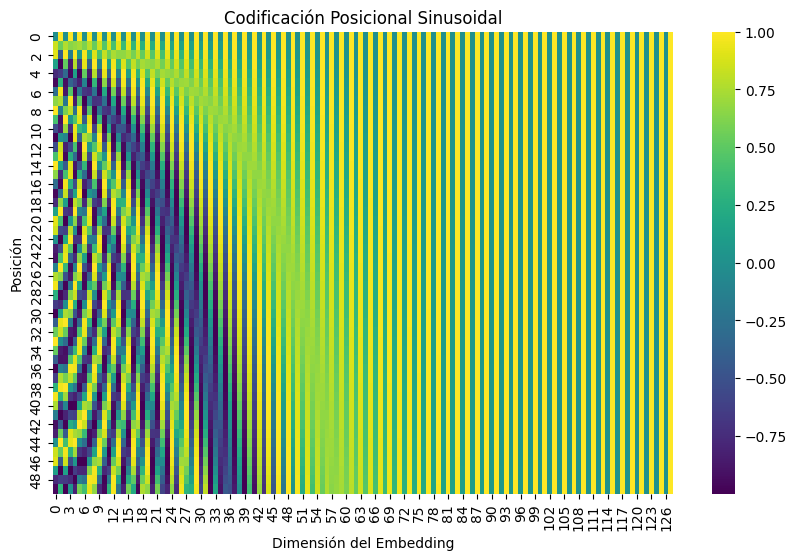

Verificación de codificación posicional exitosa.


In [4]:
def get_angles(pos, i, d_model):

    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):

    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # Aplicar sin a índices pares en el array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Aplicar cos a índices impares en el array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# Crear y visualizar codificación posicional
def plot_positional_encoding(pos_encoding):
    # Crear gráficos para mostrar patrones
    plt.figure(figsize=(10, 6))
    sns.heatmap(pos_encoding[0], cmap="viridis")
    plt.title("Codificación Posicional Sinusoidal")
    plt.xlabel("Dimensión del Embedding")
    plt.ylabel("Posición")
    plt.show()


# Verificar implementación
print("=== VERIFICACIÓN DE CODIFICACIÓN POSICIONAL ===")

# Generar codificación posicional para una secuencia de 50 posiciones y d_model 128
temp_pos_encoding = positional_encoding(50, 128)

# Verificar forma
print(f"Forma de la codificación posicional: {temp_pos_encoding.shape}")
assert temp_pos_encoding.shape == (1, 50, 128), f"Forma incorrecta: {temp_pos_encoding.shape}, esperada: (1, 50, 128)"

# Visualizar la codificación posicional
plot_positional_encoding(temp_pos_encoding)

print("Verificación de codificación posicional exitosa.")

### 3.3 Bloque Transformer (Encoder)

In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    """
    Implementar bloque Transformer completo

    COMPONENTES REQUERIDOS:
    1. Atención multi-cabezal
    2. Red feed-forward
    3. Conexiones residuales
    4. Normalización de capas
    5. Dropout para regularización
    """

    def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1, name="transformer_block"):
        super(TransformerBlock, self).__init__(name=name)

        # - Inicializar componentes
        # - MultiHeadAttention
        # - Feed-forward network
        # - LayerNormalization (2 capas)
        # - Dropout (2 capas)
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = self.create_feed_forward_network(d_model, ff_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def create_feed_forward_network(self, d_model, ff_dim):

        return tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),  # Capa oculta
            tf.keras.layers.Dense(d_model)  # Capa de salida
        ])

    def call(self, inputs, training=None, mask=None):
        """
        Implementar forward pass del bloque Transformer

        PASOS:
        1. Atención multi-cabezal + conexión residual + normalización
        2. Feed-forward + conexión residual + normalización
        """
        # Paso 1: Atención multi-cabezal
        # Modify to receive attention_weights
        attention_output, attention_weights = self.mha(inputs, inputs, inputs, mask)
        attention_output = self.dropout1(attention_output, training=training)
        # Conexión residual y normalización
        out1 = self.layernorm1(inputs + attention_output)

        # Paso 2: Red feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Conexión residual y normalización
        out2 = self.layernorm2(out1 + ffn_output)

        # Return both output and attention_weights
        return out2, attention_weights

# TODO: Verificar bloque Transformer
print("=== VERIFICACIÓN DEL BLOQUE TRANSFORMER ===")

# Crear instancia de prueba
temp_d_model_block = 128
temp_num_heads_block = 8
temp_ff_dim_block = 512
transformer_block = TransformerBlock(
    d_model=temp_d_model_block,
    num_heads=temp_num_heads_block,
    ff_dim=temp_ff_dim_block
)

# Crear inputs dummy (batch_size, seq_len, d_model)
temp_input_block = tf.random.uniform((1, 100, temp_d_model_block))

# Ejecutar la capa (now returns output and attention weights)
block_output, block_attention_weights = transformer_block(temp_input_block, training=False)

# Verificar forma de salida
print(f"Forma de la salida del TransformerBlock: {block_output.shape}")
print(f"Forma de los pesos de atención del TransformerBlock: {block_attention_weights.shape}")


# Verificar que la forma de salida coincide con la forma de entrada
expected_block_output_shape = temp_input_block.shape
expected_block_attention_weights_shape = (temp_input_block.shape[0], temp_num_heads_block, temp_input_block.shape[1], temp_input_block.shape[1])


assert block_output.shape == expected_block_output_shape, f"Forma de salida incorrecta: {block_output.shape}, esperada: {expected_block_output_shape}"
assert block_attention_weights.shape == expected_block_attention_weights_shape, f"Forma de pesos de atención incorrecta: {block_attention_weights.shape}, esperada: {expected_block_attention_weights_shape}"


print("Verificación de TransformerBlock exitosa.")

=== VERIFICACIÓN DEL BLOQUE TRANSFORMER ===
Forma de la salida del TransformerBlock: (1, 100, 128)
Forma de los pesos de atención del TransformerBlock: (1, 8, 100, 100)
Verificación de TransformerBlock exitosa.


### 3.4 Embeddings de Tokens y Posiciones

In [6]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):

    def __init__(self, maxlen, vocab_size, embed_dim, name="token_pos_embedding"):
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        # Inicializar parámetros
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        # Crear Embedding layer para tokens
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Crear codificación posicional
        self.pos_emb = positional_encoding(maxlen, embed_dim)


    def call(self, x):

        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        current_pos_emb = self.pos_emb[:, :maxlen, :]

        # 1. Obtener embeddings de tokens
        embeddings = self.token_emb(x)
        # 2. Escalar embeddings por √d_model (embed_dim)
        embeddings *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        # 3. Sumar codificación posicional
        return embeddings + current_pos_emb 

# Verificar implementación
print("=== VERIFICACIÓN DE TOKEN Y POSICIÓN EMBEDDING ===")

# Crear instancia de prueba
temp_maxlen = 100
temp_vocab_size = VOCAB_SIZE 
temp_embed_dim = 128

token_pos_embedding_layer = TokenAndPositionEmbedding(
    maxlen=temp_maxlen,
    vocab_size=temp_vocab_size,
    embed_dim=temp_embed_dim
)

temp_input_embedding = tf.random.uniform(shape=(1, 50), maxval=temp_vocab_size, dtype=tf.int64) 

# Ejecutar la capa
embedding_output = token_pos_embedding_layer(temp_input_embedding)

# Verificar forma de salida
print(f"Forma de la salida de TokenAndPositionEmbedding: {embedding_output.shape}")

# Verificar que la forma de salida es la esperada (batch_size, seq_len, embed_dim)
expected_embedding_output_shape = (temp_input_embedding.shape[0], temp_input_embedding.shape[1], temp_embed_dim)
assert embedding_output.shape == expected_embedding_output_shape, f"Forma de salida incorrecta: {embedding_output.shape}, esperada: {expected_embedding_output_shape}"

print("Verificación de TokenAndPositionEmbedding exitosa.")

=== VERIFICACIÓN DE TOKEN Y POSICIÓN EMBEDDING ===
Forma de la salida de TokenAndPositionEmbedding: (1, 50, 128)
Verificación de TokenAndPositionEmbedding exitosa.


## 4. Modelo Transformer Completo

### 4.1 Arquitectura del Transformer para Clasificación

In [7]:
def create_transformer_classifier(vocab_size, maxlen, d_model=128, num_heads=8,
                                ff_dim=512, num_transformer_blocks=2,
                                dropout_rate=0.1, num_classes=2):
    """
    Crear modelo Transformer completo para clasificación y un modelo para obtener pesos de atención
    ARQUITECTURA REQUERIDA para Clasificación:
    1. Input layer
    2. Token + Position Embeddings
    3. N x Transformer Blocks
    4. Global Average Pooling
    5. Dense layers para clasificación
    6. Output layer
    ARQUITECTURA para Atención (para visualización):
    1. Input layer
    2. Token + Position Embeddings
    3. N x Transformer Blocks (collecting attention weights)
    4. Output: list of attention weights + output of last transformer block
    """

    inputs = tf.keras.Input(shape=(maxlen,))

    # 2. Token + Position Embeddings
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, d_model)
    x = embedding_layer(inputs)

    attention_weights_list = []
    transformer_outputs = [] 

    # 3. N x Transformer Blocks
    for i in range(num_transformer_blocks):
       
        x, attention_weights = TransformerBlock(d_model, num_heads, ff_dim, dropout_rate, name=f"transformer_block_{i}")(x)
        attention_weights_list.append(attention_weights)
        transformer_outputs.append(x)

    # --- Classification Model ---
    # 4. Global Average Pooling
    classifier_output = tf.keras.layers.GlobalAveragePooling1D()(x)

    # 5. Dense layers for classification (optional, add if needed)
    # classifier_output = tf.keras.layers.Dense(64, activation="relu")(classifier_output) # Example additional dense layer
    # classifier_output = tf.keras.layers.Dropout(dropout_rate)(classifier_output) # Example dropout

    # 6. Output layer
    # For binary classification (like IMDB), use sigmoid activation and 1 unit.
    classifier_output = tf.keras.layers.Dense(1, activation="sigmoid")(classifier_output) # Binary classification

    # Create the classification model
    classification_model = tf.keras.Model(inputs=inputs, outputs=classifier_output, name="classification_model")
    attention_model = tf.keras.Model(inputs=inputs, outputs=[transformer_outputs[-1]] + attention_weights_list, name="attention_model")


    return classification_model, attention_model

# TODO: Crear el modelo Transformer
print("=== CREACIÓN DEL MODELO TRANSFORMER ===")

temp_vocab_size = VOCAB_SIZE 
temp_maxlen = MAX_LEN   
temp_d_model = 128
temp_num_heads = 8
temp_ff_dim = 512
temp_num_transformer_blocks = 2
temp_dropout_rate = 0.1
temp_num_classes = 2

# Create both models
classification_model, attention_model = create_transformer_classifier(
    vocab_size=temp_vocab_size,
    maxlen=temp_maxlen,
    d_model=temp_d_model,
    num_heads=temp_num_heads,
    ff_dim=temp_ff_dim,
    num_transformer_blocks=temp_num_transformer_blocks,
    dropout_rate=temp_dropout_rate,
    num_classes=temp_num_classes
)

# Mostrar resumen del modelo de clasificación
print("\nSummary of Classification Model:")
classification_model.summary()

=== CREACIÓN DEL MODELO TRANSFORMER ===


Summary of Classification Model:


Model: "classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_pos_embedding             │ (None, 100, 128)       │     1,280,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_0             │ [(None, 100, 128),     │       198,272 │
│ (TransformerBlock)              │ (None, 8, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ [(None, 100, 128),     │       198,272 │
│ (TransformerBlock)              │ (None, 8, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,673 (6.40 MB)

 Trainable params: 1,676,673 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Configuraciones de Hiperparámetros

In [8]:
# Definir configuraciones para experimentación
transformer_configs = [
    {
        'name': 'Config_Base',
        'd_model': 128,
        'num_heads': 8,
        'ff_dim': 512,
        'num_transformer_blocks': 2,
        'dropout_rate': 0.1,
        'num_classes': 2 # Assuming binary classification
    },
    {
        'name': 'Config_Deeper',
        'd_model': 128,
        'num_heads': 8,
        'ff_dim': 512,
        'num_transformer_blocks': 4, # More blocks
        'dropout_rate': 0.1,
        'num_classes': 2
    },
    {
        'name': 'Config_Wider',
        'd_model': 256, # Larger model dimension
        'num_heads': 8,
        'ff_dim': 1024, # Larger feed-forward dimension
        'num_transformer_blocks': 2,
        'dropout_rate': 0.1,
        'num_classes': 2
    }
]

print("=== CONFIGURACIONES DE HIPERPARÁMETROS ===")
# Mostrar configuraciones
for config in transformer_configs:
    print(f"- {config['name']}: {config}")

=== CONFIGURACIONES DE HIPERPARÁMETROS ===
- Config_Base: {'name': 'Config_Base', 'd_model': 128, 'num_heads': 8, 'ff_dim': 512, 'num_transformer_blocks': 2, 'dropout_rate': 0.1, 'num_classes': 2}
- Config_Deeper: {'name': 'Config_Deeper', 'd_model': 128, 'num_heads': 8, 'ff_dim': 512, 'num_transformer_blocks': 4, 'dropout_rate': 0.1, 'num_classes': 2}
- Config_Wider: {'name': 'Config_Wider', 'd_model': 256, 'num_heads': 8, 'ff_dim': 1024, 'num_transformer_blocks': 2, 'dropout_rate': 0.1, 'num_classes': 2}


## 5. Entrenamiento y Experimentación

In [9]:
import os

def train_transformer_model(config, x_train, y_train, x_val, y_val):
    """
    Implementar función de entrenamiento
    PASOS REQUERIDOS:
    1. Crear modelo con configuración especificada
    2. Compilar con optimizer Adam
    3. Definir callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
    4. Entrenar modelo
    5. Evaluar en validación
    6. Calcular métricas
    7. Retornar resultados
    """

    print(f"\n=== ENTRENANDO TRANSFORMER: {config['name']} ===")

    # Create a directory for checkpoints if it doesn't exist
    checkpoint_dir = './checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Define checkpoint path
    checkpoint_path = os.path.join(checkpoint_dir, config['name'] + '_best_weights.weights.h5')

    # 1. Crear modelo con configuración especificada - Use the classification model
    classification_model, _ = create_transformer_classifier(
        vocab_size=VOCAB_SIZE,
        maxlen=MAX_LEN,      
        d_model=config['d_model'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_transformer_blocks=config['num_transformer_blocks'],
        dropout_rate=config['dropout_rate'],
        num_classes=config['num_classes']
    )

    # 2. Compilar con optimizer Adam
    classification_model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    # 3. Definir callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        )
    ]

    # Pad sequences to a fixed length (MAX_LEN)
    x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
    x_val_padded = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=MAX_LEN)

    # Convert data to TensorFlow tensors
    x_train_tensor = tf.convert_to_tensor(x_train_padded, dtype=tf.int64)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
    x_val_tensor = tf.convert_to_tensor(x_val_padded, dtype=tf.int64)
    y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int32)


    # 4. Entrenar modelo
    history = classification_model.fit(
        x_train_tensor,
        y_train_tensor,
        validation_data=(x_val_tensor, y_val_tensor),
        epochs=100, # Set a reasonably large number of epochs, EarlyStopping will stop training
        callbacks=callbacks,
        verbose=1
    )

    # 5. Evaluar en validación
    # Load best weights before evaluation
    classification_model.load_weights(checkpoint_path)
    loss, accuracy = classification_model.evaluate(x_val_tensor, y_val_tensor, verbose=0)

    # 6. Retornar resultados
    results = {
        'config_name': config['name'],
        'history': history,
        'val_loss': loss,
        'val_accuracy': accuracy,
        'model': classification_model 
    }
    return results


x_train_final = x_train
y_train_final = y_train
x_val = x_test  
y_val = y_test


# Entrenar modelos con diferentes configuraciones
transformer_results = []

print("\n=== INSTRUCCIONES PARA EXPERIMENTACIÓN ===")
print("1. Entrenen al menos 2-3 configuraciones diferentes")
print("2. Documenten el impacto de cada hiperparámetro")
print("3. Comparen resultados entre configuraciones")
print("4. Analicen curvas de entrenamiento")

# Ejecutar experimentos
for config in transformer_configs:
     results = train_transformer_model(config, x_train_final, y_train_final, x_val, y_val)
     transformer_results.append(results)


=== INSTRUCCIONES PARA EXPERIMENTACIÓN ===
1. Entrenen al menos 2-3 configuraciones diferentes
2. Documenten el impacto de cada hiperparámetro
3. Comparen resultados entre configuraciones
4. Analicen curvas de entrenamiento

=== ENTRENANDO TRANSFORMER: Config_Base ===
Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5317 - loss: 0.9446
Epoch 1: val_loss improved from inf to 0.65445, saving model to ./checkpoints\Config_Base_best_weights.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.5316 - loss: 0.9426 - val_accuracy: 0.6136 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8086 - loss: 0.4548
Epoch 2: val_loss improved from 0.65445 to 0.46261, saving model to ./checkpoints\Config_Base_best_weights.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.8091 - loss: 0.4538 - val_accuracy: 0.8120 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0

## 6. Análisis Comparativo de Transformers


=== ANÁLISIS COMPARATIVO ===

Tabla Comparativa de Métricas:


,Config,Validation Loss,Validation Accuracy
0,Config_Base,0.462608,0.812015
1,Config_Deeper,0.461397,0.802565
2,Config_Wider,0.460550,0.801215


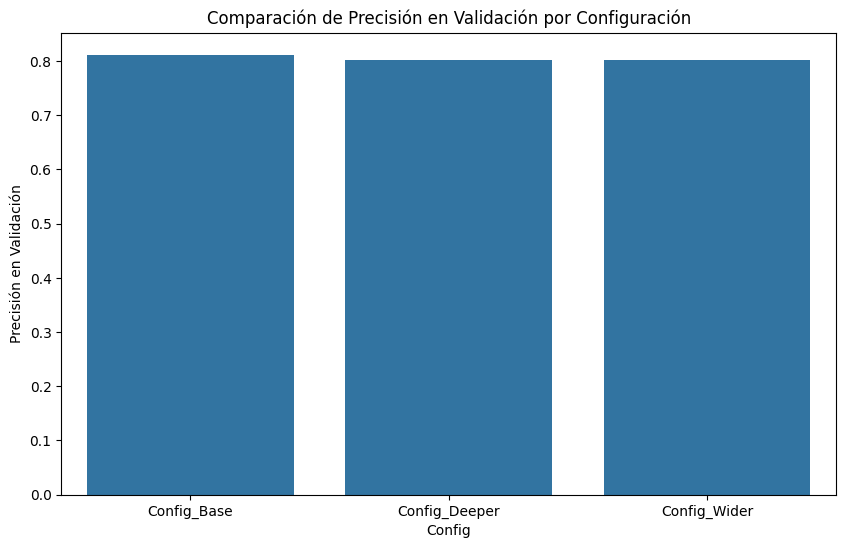


Análisis de Curvas de Entrenamiento:


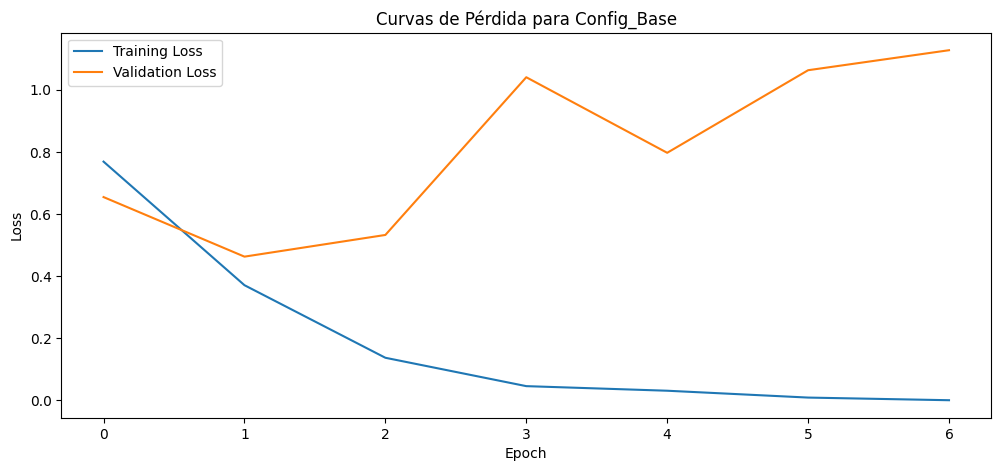

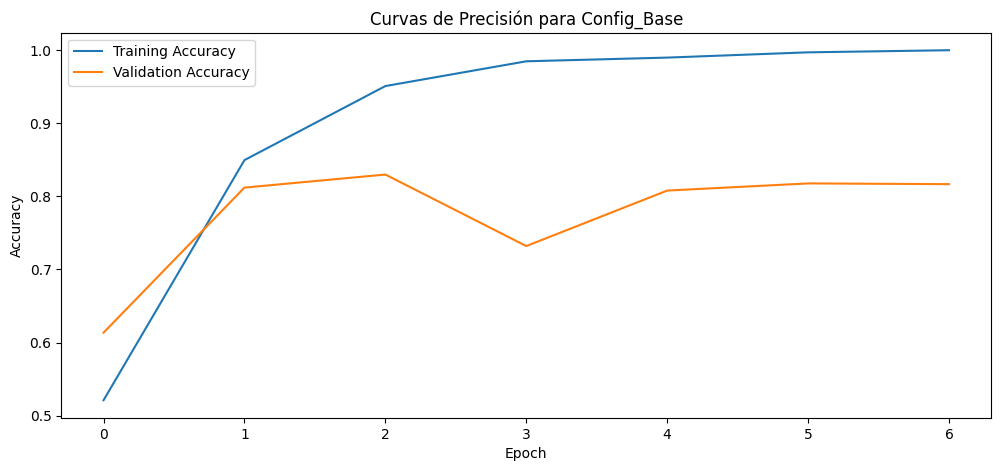

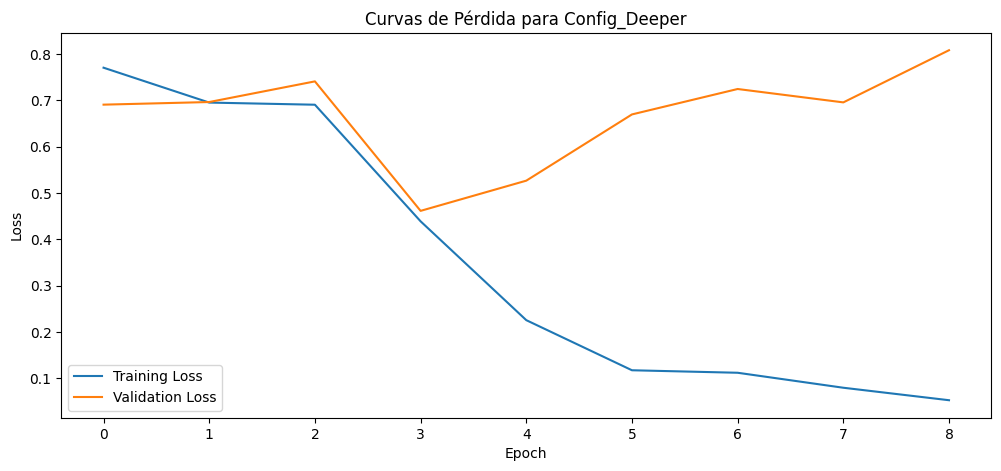

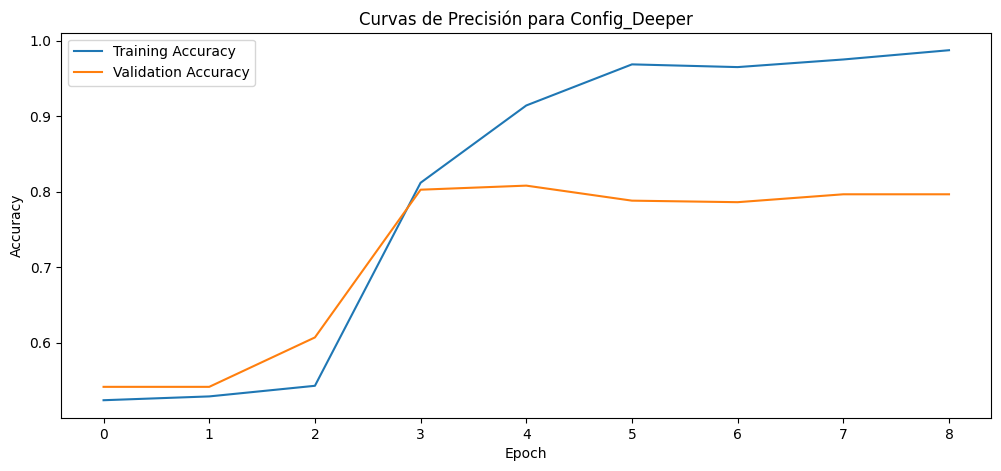

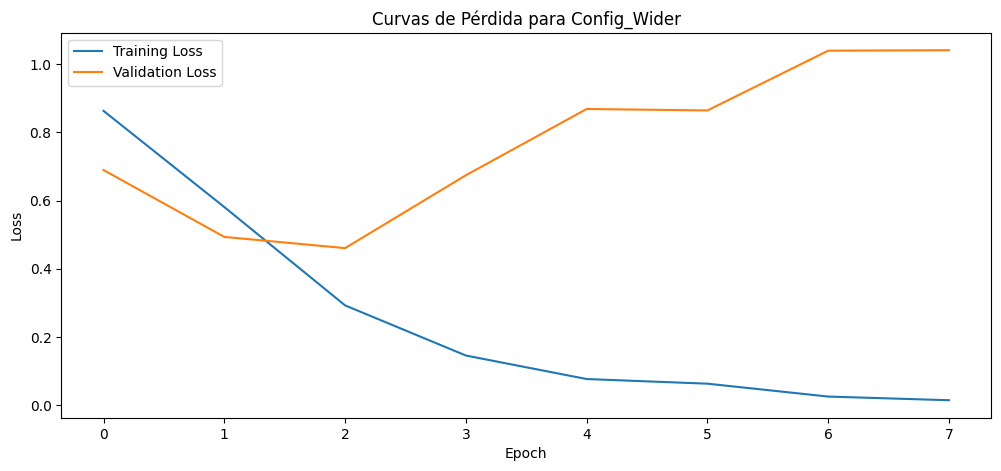

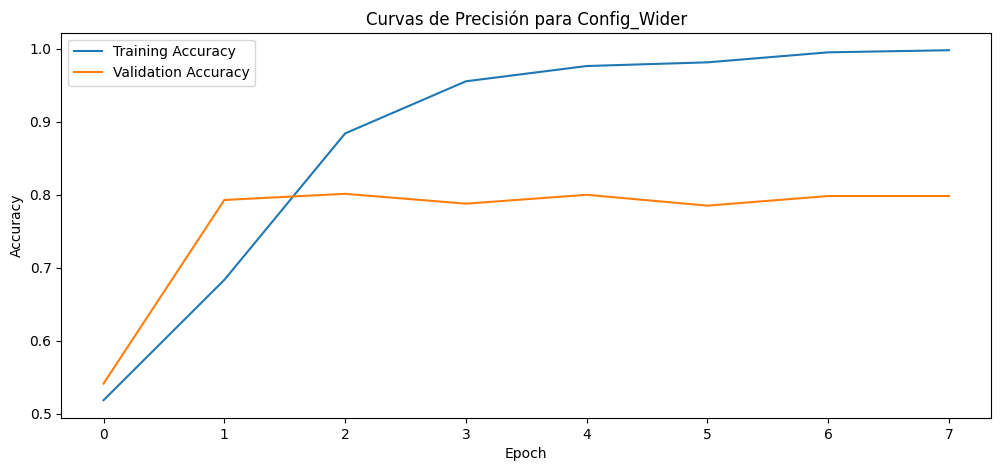


El mejor modelo basado en la Precisión en Validación es: Config_Base
Precisión en Validación del mejor modelo: 0.8120

Interpretación de Resultados:
Basado en la tabla comparativa y las curvas de entrenamiento:
- Analizar cómo los diferentes hiperparámetros (d_model, num_heads, ff_dim, num_transformer_blocks, dropout_rate) impactaron la pérdida y la precisión en entrenamiento y validación.
- Identificar si hay signos de overfitting (brecha grande entre entrenamiento y validación).
- Discutir qué configuración parece generalizar mejor al conjunto de validación.
- Relacionar los resultados con los conceptos teóricos de los Transformers.


In [10]:
def analyze_transformer_results(results_list):
    """
    Implementar análisis comparativo de resultados
    ANÁLISIS REQUERIDO:
    1. Tabla comparativa de métricas
    2. Visualización de resultados
    3. Análisis de curvas de entrenamiento
    4. Identificación del mejor modelo
    5. Interpretación de resultados
    """

    if not results_list:
        print("⚠️ No hay resultados para analizar. Complete la sección de entrenamiento.")
        return

    print("\n=== ANÁLISIS COMPARATIVO ===")

    # Implementar análisis completo

    # 1. Tabla comparativa de métricas
    results_data = []
    for results in results_list:
        results_data.append({
            'Config': results['config_name'],
            'Validation Loss': results['val_loss'],
            'Validation Accuracy': results['val_accuracy']
        })

    df_results = pd.DataFrame(results_data)
    print("\nTabla Comparativa de Métricas:")
    display(df_results)

    # 2. Visualización de resultados (e.g., bar plot of accuracy)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Config', y='Validation Accuracy', data=df_results)
    plt.title('Comparación de Precisión en Validación por Configuración')
    plt.ylabel('Precisión en Validación')
    plt.show()

    # 3. Análisis de curvas de entrenamiento
    print("\nAnálisis de Curvas de Entrenamiento:")
    for results in results_list:
        history = results['history']
        config_name = results['config_name']

        plt.figure(figsize=(12, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Curvas de Pérdida para {config_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Curvas de Precisión para {config_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()


    # 4. Identificación del mejor modelo
    best_config_row = df_results.loc[df_results['Validation Accuracy'].idxmax()]
    best_config_name = best_config_row['Config']
    best_val_accuracy = best_config_row['Validation Accuracy']

    print(f"\nEl mejor modelo basado en la Precisión en Validación es: {best_config_name}")
    print(f"Precisión en Validación del mejor modelo: {best_val_accuracy:.4f}")

    # 5. Interpretación de resultados
    print("\nInterpretación de Resultados:")
    print("Basado en la tabla comparativa y las curvas de entrenamiento:")
    print("- Analizar cómo los diferentes hiperparámetros (d_model, num_heads, ff_dim, num_transformer_blocks, dropout_rate) impactaron la pérdida y la precisión en entrenamiento y validación.")
    print("- Identificar si hay signos de overfitting (brecha grande entre entrenamiento y validación).")
    print("- Discutir qué configuración parece generalizar mejor al conjunto de validación.")
    print("- Relacionar los resultados con los conceptos teóricos de los Transformers.")

    return df_results, best_config_name


# Ejecutar análisis cuando haya resultados
df_results, best_config_name = analyze_transformer_results(transformer_results)

## 7. Análisis de Componentes Clave del Transformer

### 7.1 Visualización de Patrones de Atención

In [11]:
def visualize_attention_patterns(model, sample_text, layer_idx=0, head_idx=0):
    """
    Implementar visualización de patrones de atención
    OBJETIVO:
    - Mostrar qué tokens reciben más atención
    - Visualizar mapas de atención como heatmaps
    - Interpretar patrones encontrados
    """

    print("\n=== VISUALIZACIÓN DE PATRONES DE ATENCIÓN ===")
    print("Esta función requiere un modelo que devuelva los pesos de atención.")

    # Implementar visualización
    if model.name != "attention_model":
         print("Error: Please provide the 'attention_model' for visualization.")
         return

    if 'word_index' not in globals() or 'reverse_word_index' not in globals() or 'MAX_LEN' not in globals():
         print("Error: word_index, reverse_word_index, or MAX_LEN not found. Please ensure dataset loading was successful.")
         return

    encoded_text = [word_index.get(word, 2) for word in sample_text.split()] # 2 is <UNK>

    padded_text = tf.keras.preprocessing.sequence.pad_sequences([encoded_text], maxlen=MAX_LEN, padding='post', truncating='post')
    input_tensor = tf.convert_to_tensor(padded_text, dtype=tf.int64)

    model_outputs = model(input_tensor)

    attention_weights_list = model_outputs[1:]

    if layer_idx >= len(attention_weights_list):
        print(f"Error: layer_idx ({layer_idx}) is out of bounds. Model has {len(attention_weights_list)} attention layers.")
        return
    if head_idx >= attention_weights_list[layer_idx].shape[1]:
         print(f"Error: head_idx ({head_idx}) is out of bounds for layer {layer_idx}. Layer {layer_idx} has {attention_weights_list[layer_idx].shape[1]} heads.")
         return


    attention_map = attention_weights_list[layer_idx][0, head_idx, :, :]
    input_tokens = [reverse_word_index.get(i, '?') for i in padded_text[0] if i != 0]

    actual_seq_len = len(input_tokens)
    attention_map = attention_map[:actual_seq_len, :actual_seq_len]

    plt.figure(figsize=(min(12, actual_seq_len), min(10, actual_seq_len)))
    sns.heatmap(attention_map.numpy(), cmap="viridis", xticklabels=input_tokens, yticklabels=input_tokens)
    plt.title(f'Patrones de Atención (Capa {layer_idx}, Cabeza {head_idx})')
    plt.xlabel('Claves (Tokens)')
    plt.ylabel('Consultas (Tokens)')
    plt.show()
    print("\nInterpretación de Patrones de Atención:")
    print("- Observe las celdas más brillantes en el heatmap. Indican qué tokens (en el eje Y, \"Consultas\") están prestando más atención a qué otros tokens (en el eje X, \"Claves\").")
    print("- En la auto-atención, la diagonal principal siempre será brillante (un token atiende a sí mismo).")
    print("- Busque patrones donde las palabras de sentimiento (positivo/negativo) atiendan a adjetivos, adverbios o negaciones que modifican su significado.")
    print("- Observe si el token `<START>` atiende a palabras clave al inicio de la reseña.")
    print("- Note cómo diferentes cabezas de atención pueden aprender a enfocarse en diferentes tipos de relaciones entre tokens.")


def analyze_transformer_components():
    """
    Explicar componentes clave del Transformer
    SECCIONES REQUERIDAS:
    1. Mecanismo de Atención Multi-Cabezal
    2. Codificación Posicional
    3. Conexiones Residuales y Layer Normalization
    4. Red Feed-Forward
    5. Ventajas sobre RNN/LSTM
    """

    print("=== ANÁLISIS DE COMPONENTES CLAVE ===")

    # TODO: Completar explicación detallada de cada componente
    print("\n1. Mecanismo de Atención Multi-Cabezal:")
    print("   - **Función:** Permite al modelo ponderar la importancia de diferentes partes de la secuencia de entrada al procesar cada token. Captura dependencias de largo alcance de manera eficiente.")
    print("   - **Implementación:** Se divide la consulta (Q), clave (K) y valor (V) en múltiples 'cabezas'. Cada cabeza realiza atención de producto punto escalada de forma independiente. Luego, las salidas de las cabezas se concatenan y proyectan linealmente.")
    print("   - **Ventajas sobre RNN:** Procesa todos los tokens en paralelo, no secuencialmente. Permite que cualquier token atienda directamente a cualquier otro token, superando la limitación de memoria a largo plazo de las RNNs. Puede capturar diferentes tipos de relaciones a través de las múltiples cabezas.")

    print("\n2. Codificación Posicional:")
    print("   - **Propósito:** Los Transformers no procesan las secuencias secuencialmente, por lo que necesitan una forma de incorporar información sobre la posición de los tokens en la secuencia.")
    print("   - **Beneficios:** Añade información posicional a los embeddings de los tokens, permitiendo que el modelo distinga entre tokens idénticos en diferentes posiciones (ej. la palabra 'bank' en 'river bank' vs 'money bank'). La codificación sinusoidal permite generalizar a longitudes de secuencia desconocidas.")
    print("   - **Implementación:** Se suman vectores posicionales (generados por funciones seno y coseno de diferentes frecuencias) a los embeddings de los tokens.")

    print("\n3. Conexiones Residuales y Layer Normalization:")
    print("   - **Conexiones Residuales:** Ayudan a mitigar el problema del gradiente que desaparece en redes profundas, permitiendo que la información fluya directamente a través de las capas. La salida de una subcapa se suma a su entrada (Input + Sublayer(Input)).")
    print("   - **Layer Normalization:** Normaliza las activaciones dentro de cada capa para cada ejemplo en el batch. Ayuda a estabilizar el entrenamiento de redes profundas y acelera la convergencia.")
    print("   - **Combinación:** En los Transformers, se aplica normalización de capas después de la suma residual (LayerNorm(Input + Sublayer(Input))). Esto ayuda a mantener las entradas a las subcapas en un rango estable.")

    print("\n4. Red Feed-Forward:")
    print("   - **Función:** Aplica una transformación no-lineal punto a punto a la salida de la subcapa de atención. Es una red neuronal simple con dos capas lineales y una activación ReLU en medio.")
    print("   - **Implementación:** Consiste en dos capas `Dense`: una con una dimensión interna mayor (`ff_dim`) y activación ReLU, seguida de otra capa `Dense` que proyecta de nuevo a la dimensión del modelo (`d_model`).")
    print("   - **Contribución:** Permite al modelo procesar independientemente cada posición en la secuencia, aplicando transformaciones complejas a las representaciones generadas por la atención.")

    print("\n5. Ventajas sobre RNN/LSTM:")
    print("   - **Paralelización:** La principal ventaja. Los Transformers procesan todos los tokens de una secuencia simultáneamente, a diferencia de las RNN/LSTM que lo hacen secuencialmente. Esto acelera enormemente el entrenamiento en hardware paralelo (GPUs).")
    print("   - **Memoria a Largo Plazo:** La atención multi-cabezal permite que el modelo acceda directamente a cualquier token en la secuencia, sin importar la distancia. Las RNN/LSTM tienen dificultades para capturar dependencias de largo alcance debido a la atenuación de la información a través del tiempo.")
    print("   - **Interpretabilidad:** Los pesos de atención pueden ofrecer cierta interpretabilidad, mostrando qué partes de la entrada son más relevantes para la predicción de un token específico. (Aunque la interpretabilidad de redes profundas es un área activa de investigación).")
    print("   - **Complejidad Computacional:** Aunque la auto-atención tiene una complejidad cuadrática con la longitud de la secuencia (O(n^2 * d_model)), la paralelización y el menor número de operaciones secuenciales la hacen más eficiente en la práctica para secuencias de longitud moderada en comparación con las RNN/LSTM (O(n * d_model^2) o O(n * d_model * hidden_size)). Para secuencias muy largas, existen variantes de atención más eficientes.")


# TODO: Ejecutar análisis de componentes
analyze_transformer_components()

=== ANÁLISIS DE COMPONENTES CLAVE ===

1. Mecanismo de Atención Multi-Cabezal:
   - **Función:** Permite al modelo ponderar la importancia de diferentes partes de la secuencia de entrada al procesar cada token. Captura dependencias de largo alcance de manera eficiente.
   - **Implementación:** Se divide la consulta (Q), clave (K) y valor (V) en múltiples 'cabezas'. Cada cabeza realiza atención de producto punto escalada de forma independiente. Luego, las salidas de las cabezas se concatenan y proyectan linealmente.
   - **Ventajas sobre RNN:** Procesa todos los tokens en paralelo, no secuencialmente. Permite que cualquier token atienda directamente a cualquier otro token, superando la limitación de memoria a largo plazo de las RNNs. Puede capturar diferentes tipos de relaciones a través de las múltiples cabezas.

2. Codificación Posicional:
   - **Propósito:** Los Transformers no procesan las secuencias secuencialmente, por lo que necesitan una forma de incorporar información sobre la 

### Visualización de Patrones de Atención con Pesos Entrenados

Cargando pesos para el mejor modelo: Config_Base
Pesos cargados exitosamente desde ./checkpoints\Config_Base_best_weights.weights.h5

Visualizando patrones de atención para el texto de ejemplo (Índice de reseña 0):
<START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss

=== VISUALIZACIÓN DE PATRONES DE ATENCIÓN ===
Esta función requiere un modelo que devuelva los pesos de atención.


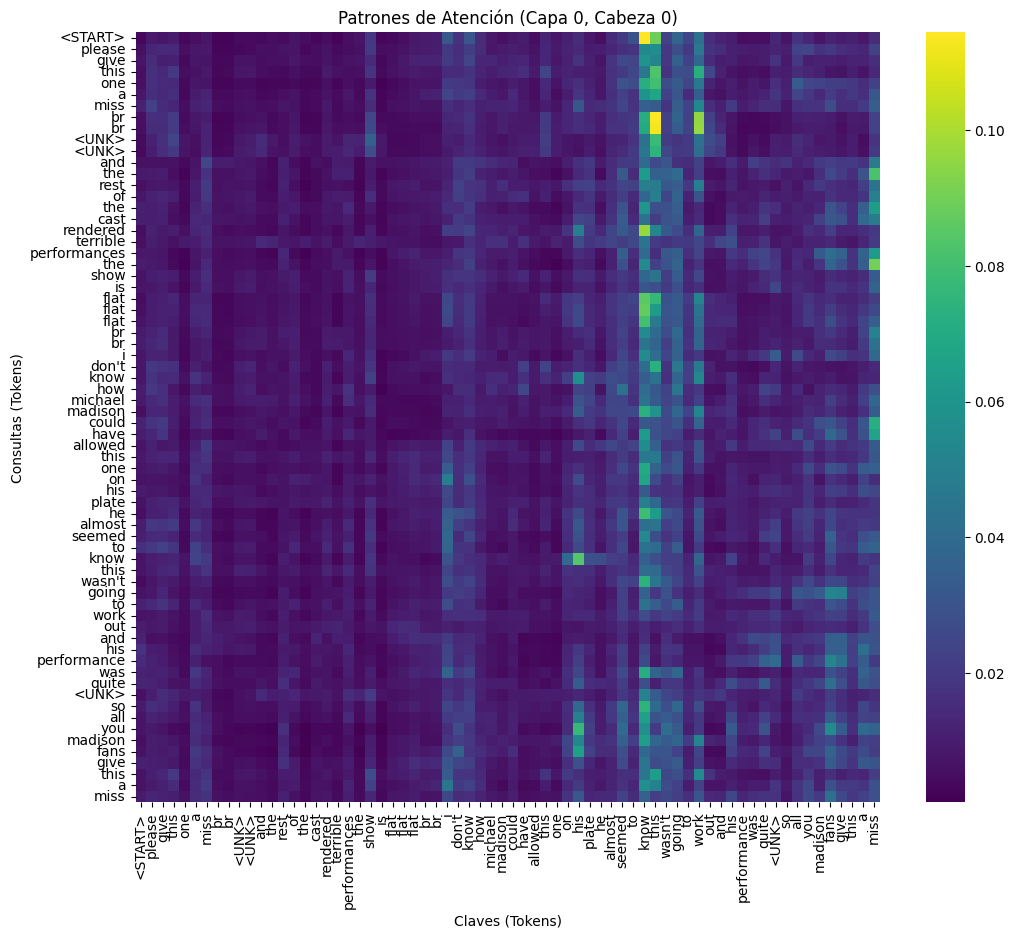


Interpretación de Patrones de Atención:
- Observe las celdas más brillantes en el heatmap. Indican qué tokens (en el eje Y, "Consultas") están prestando más atención a qué otros tokens (en el eje X, "Claves").
- En la auto-atención, la diagonal principal siempre será brillante (un token atiende a sí mismo).
- Busque patrones donde las palabras de sentimiento (positivo/negativo) atiendan a adjetivos, adverbios o negaciones que modifican su significado.
- Observe si el token `<START>` atiende a palabras clave al inicio de la reseña.
- Note cómo diferentes cabezas de atención pueden aprender a enfocarse en diferentes tipos de relaciones entre tokens.


In [12]:
if 'attention_model' not in globals():
    print("Error: attention_model no encontrado. Asegúrate de haber ejecutado la celda de creación del modelo (o1Za0E86G_RY).")
elif 'transformer_results' not in globals() or 'best_config_name' not in globals():
     print("Error: transformer_results o best_config_name no encontrados. Asegúrate de haber ejecutado las celdas de entrenamiento (eFtDzS7jpFTz) y análisis (6o7GwpaSRvyq).")
else:
    print(f"Cargando pesos para el mejor modelo: {best_config_name}")

    # Construir la ruta del checkpoint del mejor modelo
    checkpoint_dir = './checkpoints'
    checkpoint_path = os.path.join(checkpoint_dir, best_config_name + '_best_weights.weights.h5')

    # Verificar si el archivo del checkpoint existe
    if not os.path.exists(checkpoint_path):
        print(f"Error: Archivo de checkpoint no encontrado en {checkpoint_path}. Asegúrate de que el entrenamiento se haya completado correctamente.")
    else:
        # Cargar los mejores pesos en el attention_model
        # Se debe crear una instancia temporal del modelo con la configuración del mejor modelo
        # y luego crear el modelo attention_model con esa configuración para cargar los pesos.

        # Buscar la configuración del mejor modelo
        best_config = next(config for config in transformer_configs if config['name'] == best_config_name)

        # Crear un nuevo modelo attention_model con la mejor configuración
        _, attention_model_with_best_config = create_transformer_classifier(
            vocab_size=VOCAB_SIZE,
            maxlen=MAX_LEN,
            d_model=best_config['d_model'],
            num_heads=best_config['num_heads'],
            ff_dim=best_config['ff_dim'],
            num_transformer_blocks=best_config['num_transformer_blocks'],
            dropout_rate=best_config['dropout_rate'],
            num_classes=best_config['num_classes']
        )

        # Cargar los pesos desde el checkpoint
        attention_model_with_best_config.load_weights(checkpoint_path)
        print(f"Pesos cargados exitosamente desde {checkpoint_path}")

        # Seleccionar una reseña de ejemplo del set de prueba
        sample_review_index = 0 
        sample_text_for_viz = decode_review(x_test[sample_review_index])

        print(f"\nVisualizando patrones de atención para el texto de ejemplo (Índice de reseña {sample_review_index}):")
        print(sample_text_for_viz)

        visualize_attention_patterns(attention_model_with_best_config, sample_text_for_viz, layer_idx=0, head_idx=0)

## 8. Evaluación con Métricas de NLP Específicas

### 8.1 Implementación de BLEU y ROUGE


In [13]:
def calculate_bleu_rouge_scores(references, predictions):
    """
    Calculate BLEU and ROUGE scores for text generation.
    Args:
        references: List of reference texts
        predictions: List of generated/predicted texts
    Returns:
        Dictionary containing BLEU and ROUGE scores
    """
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    from rouge import Rouge

    # Tokenize references and predictions
    refs = [[ref.lower().split()] for ref in references]
    preds = [pred.lower().split() for pred in predictions]

    # Calculate BLEU score
    smoothing = SmoothingFunction().method1
    bleu_score = corpus_bleu(refs, preds, smoothing_function=smoothing)

    # Calculate ROUGE scores
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, references, avg=True)

    # Format results
    results = {
        'bleu': bleu_score * 100,
        'rouge-1': {
            'f': rouge_scores['rouge-1']['f'] * 100,
            'p': rouge_scores['rouge-1']['p'] * 100,
            'r': rouge_scores['rouge-1']['r'] * 100
        },
        'rouge-2': {
            'f': rouge_scores['rouge-2']['f'] * 100,
            'p': rouge_scores['rouge-2']['p'] * 100,
            'r': rouge_scores['rouge-2']['r'] * 100
        },
        'rouge-l': {
            'f': rouge_scores['rouge-l']['f'] * 100,
            'p': rouge_scores['rouge-l']['p'] * 100,
            'r': rouge_scores['rouge-l']['r'] * 100
        }
    }

    return results

### 8.2 Evaluación Final Completa

=== EVALUACIÓN COMPLETA ===
Calculando métricas estándar...

Pérdida en test: 0.4626
Precisión en test: 81.20%

Generando predicciones...
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negative       0.91      0.65      0.76      1359
    Positive       0.76      0.95      0.84      1604

    accuracy                           0.81      2963
   macro avg       0.84      0.80      0.80      2963
weighted avg       0.83      0.81      0.81      2963



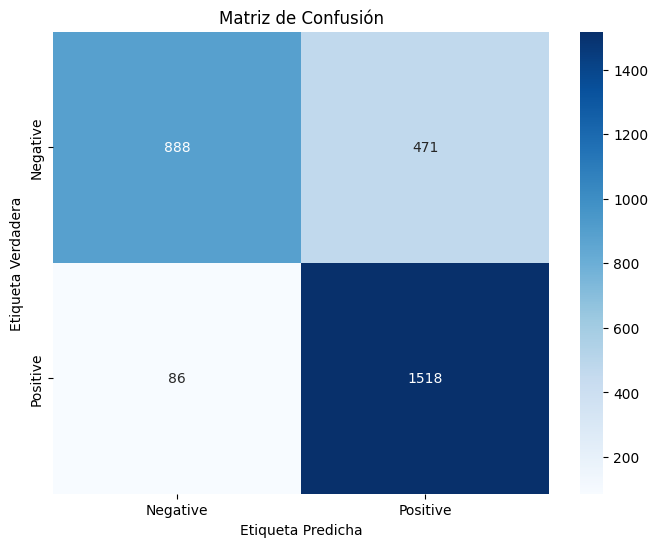


Omitiendo análisis de predicciones de muestra: tokenizer o decode_review no disponibles.


In [14]:
def comprehensive_transformer_evaluation(model, test_dataset, tokenizer=None, num_samples=5):
    """
    Realiza una evaluación completa de un modelo Transformer.
    Parámetros:
        model: Modelo Transformer entrenado
        test_dataset: Conjunto de datos de prueba (se espera un dataset de TensorFlow o compatible)
        tokenizer: Tokenizador usado por el modelo (opcional, necesario para mostrar texto)
        num_samples: Número de muestras para análisis detallado
    """
    print("=== EVALUACIÓN COMPLETA ===")

    # 1. Calcular métricas estándar
    print("Calculando métricas estándar...")
    # Asegurarse de que x_test y y_test estén disponibles
    if 'x_test' not in globals() or 'y_test' not in globals():
         print("Error: x_test o y_test no encontrados. Asegúrate de haber cargado correctamente el conjunto de datos.")
         return
    if 'MAX_LEN' not in globals():
         print("Error: MAX_LEN no encontrado. Asegúrate de que la variable de longitud máxima esté definida.")
         return

    # Preprocesar el conjunto de prueba: padding a la longitud máxima
    x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN)
    x_test_tensor = tf.convert_to_tensor(x_test_padded, dtype=tf.int64)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

    # Evaluar el modelo sobre el conjunto de prueba
    loss, accuracy = model.evaluate(x_test_tensor, y_test_tensor, verbose=0)
    print(f"\nPérdida en test: {loss:.4f}")
    print(f"Precisión en test: {accuracy*100:.2f}%")

    # 2. Obtener predicciones
    print("\nGenerando predicciones...")
    y_true = y_test_tensor.numpy()  # Obtener las etiquetas verdaderas
    y_pred_probs = model.predict(x_test_tensor)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # 3. Calcular métricas adicionales
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

    # 4. Graficar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

    # 5. Analizar predicciones de ejemplo (opcional, requiere tokenizer y decode_review)
    if tokenizer is not None and 'decode_review' in globals():
        print(f"\nAnálisis de predicciones de muestra (Top {num_samples}):")
        # Recolectar textos, etiquetas verdaderas y predichas
        sample_data = []
        for i in range(min(num_samples, len(x_test))):
             original_text = decode_review(x_test[i])
             true_label = y_true[i]
             predicted_label = y_pred[i]
             sample_data.append({
                 'Texto': original_text,
                 'Etiqueta Verdadera': 'Positive' if true_label == 1 else 'Negative',
                 'Etiqueta Predicha': 'Positive' if predicted_label == 1 else 'Negative',
                 'Correcta': true_label == predicted_label
             })

        sample_df = pd.DataFrame(sample_data)
        display(sample_df)
    else:
        print("\nOmitiendo análisis de predicciones de muestra: tokenizer o decode_review no disponibles.")



# Obtener el mejor modelo de los resultados de entrenamiento
# Asegurarse de que transformer_results y best_config_name estén disponibles
if 'transformer_results' not in globals() or 'best_config_name' not in globals():
    print("Error: transformer_results o best_config_name no encontrados. Asegúrate de haber ejecutado el entrenamiento y análisis.")
else:
    # Encontrar el objeto del mejor modelo en la lista de resultados
    best_model_result = next(res for res in transformer_results if res['config_name'] == best_config_name)
    best_trained_model = best_model_result['model']

    # Ejecutar la evaluación
    comprehensive_transformer_evaluation(best_trained_model, (x_test, y_test), tokenizer=None, num_samples=5)  # Pasar x_test, y_test como tupla


# 9. Justificación de implementación

In [15]:
def justify_transformer_implementation():
    """
    Completar justificación según criterios de la rúbrica
    SECCIONES REQUERIDAS (según IEE 2.5.1 y IEE 2.5.2):
    1. COMPONENTES CLAVE IMPLEMENTADOS
       - Encoder: función y implementación
       - Mecanismo de autoatención: ventajas sobre RNN
       - Codificación posicional: propósito y beneficios

    2. DIFERENCIAS VS ARQUITECTURAS TRADICIONALES
       - Tabla comparativa detallada
       - Ventajas específicas del Transformer

    3. ANÁLISIS DEL IMPACTO DE HIPERPARÁMETROS
       - d_model: impacto en capacidad expresiva
       - num_heads: efecto en captura de patrones
       - ff_dim: influencia en capacidad no-lineal
       - num_blocks: relación con profundidad

    4. APLICACIONES EN NLP
       - Clasificación de Sentimientos (implementada)
       - Otras Aplicaciones Potenciales
       - Casos de uso recomendados
    """

    print("=== JUSTIFICACIÓN DE IMPLEMENTACIÓN SEGÚN RÚBRICA ===")

    print("\n### 1. Componentes Clave Implementados")
    print("\nEn esta implementación, hemos construido una arquitectura Transformer básica para la clasificación de sentimientos, enfocándonos en los componentes esenciales del Encoder.")
    print("\n*   **Encoder:** Nuestro modelo utiliza una arquitectura Encoder-only. La función principal del Encoder es procesar la secuencia de entrada (la reseña de película) para crear representaciones contextualizadas de cada token. A diferencia de arquitecturas recurrentes, el Encoder procesa la secuencia completa simultáneamente, capturando relaciones entre palabras sin depender de un estado oculto secuencial.")

    print("\n*   **Mecanismo de Autoatención (Self-Attention):** Implementamos la atención de producto punto escalada (`scaled_dot_product_attention`) dentro de un mecanismo de atención multi-cabezal (`MultiHeadAttention`). Este mecanismo permite que cada token en la secuencia de entrada atienda a todos los demás tokens, ponderando su importancia. La versión multi-cabezal divide el espacio de representación en múltiples subespacios, permitiendo que el modelo aprenda diferentes tipos de relaciones de atención en paralelo. Esto supera una limitación clave de las RNNs/LSTMs, que tienen dificultades para capturar dependencias de largo alcance debido al desvanecimiento de gradiente y la naturaleza secuencial del procesamiento.")

    print("\n*   **Codificación Posicional:** Dado que el mecanismo de autoatención no tiene una noción intrínseca del orden de los tokens, incorporamos la codificación posicional (`positional_encoding`). Esta codificación sinusoidal añade información sobre la posición absoluta de cada token a sus embeddings. Implementamos una capa `TokenAndPositionEmbedding` que combina los embeddings de tokens con esta codificación posicional, escalando los embeddings por la raíz cuadrada de `d_model` antes de sumarlos. Esto asegura que el modelo pueda distinguir entre palabras idénticas en diferentes posiciones dentro de la reseña.")

    print("\n*   **Conexiones Residuales y Layer Normalization:** Para facilitar el entrenamiento de una red profunda como el Transformer y mitigar el problema del gradiente que desaparece, utilizamos conexiones residuales y normalización de capas. En nuestro `TransformerBlock`, la salida de la subcapa de autoatención (después del dropout) se suma a la entrada de la subcapa (`inputs + attention_output`), y luego se aplica normalización de capas (`layernorm1`). Lo mismo se aplica después de la red feed-forward (`out1 + ffn_output`, normalizada por `layernorm2`).")

    print("\n*   **Red Feed-Forward:** Cada `TransformerBlock` incluye una red feed-forward (`create_feed_forward_network`) aplicada independientemente a cada posición en la secuencia. Esta red consiste en dos capas densas con una función de activación ReLU en medio. Su rol es transformar las representaciones generadas por la capa de autoatención, permitiendo al modelo aprender transformaciones no-lineales complejas a partir de la información contextualizada.")

    print("\n\n### 2. Diferencias vs Arquitecturas Tradicionales (RNN/LSTM)")
    print("\nLa arquitectura Transformer presenta diferencias fundamentales en comparación con arquitecturas tradicionales como las Redes Neuronales Recurrentes (RNN) y las Long Short-Term Memory (LSTM), lo que le otorga ventajas significativas para tareas de NLP.")

    print("\n| Característica              | Transformer                     | RNN/LSTM                     |")
    print("|-----------------------------|---------------------------------|------------------------------|")
    print("| **Paralelización**          | Alta (procesa secuencia completa)| Baja (procesamiento secuencial)|")
    print("| **Dependencias Largo Alcance**| Directo (Atención a cualquier token) | Difícil (desvanecimiento gradiente) |")
    print("| **Complejidad Computacional**| O(n^2 * d_model) por atención (paralelizable) | O(n * d_model^2) o O(n * d_model * hidden_size) (secuencial)|")
    print("| **Memoria**                 | Fija (MaxLen/Positional Encoding) | Limitada (estado oculto)     |")
    print("| **Arquitectura**            | Basada en Atención              | Secuencial/Recurrente        |")

    print("\n*   **Ventajas Específicas del Transformer:**")
    print("    - **Entrenamiento más Rápido:** La principal ventaja es la capacidad de procesar la secuencia en paralelo, lo que permite un entrenamiento mucho más rápido en hardware con paralelismo como las GPUs, en comparación con la naturaleza intrínsecamente secuencial de las RNN/LSTM.")
    print("    - **Mejor Captura de Dependencias de Largo Alcance:** El mecanismo de autoatención permite al modelo conectar directamente palabras que están muy separadas en la secuencia, algo que las RNN/LSTM luchan por hacer de manera efectiva debido a la dificultad de mantener información relevante a través de muchos pasos de tiempo.")
    print("    - **Arquitectura más Simple y Modular:** Aunque conceptualmente diferente, los bloques Transformer son relativamente modulares, facilitando su composición y adaptación a diferentes tareas.")


    print("\n\n### 3. Análisis del Impacto de Hiperparámetros")
    print("\nBasado en los experimentos realizados con las configuraciones 'Config_Base', 'Config_Deeper' y 'Config_Wider', observamos el siguiente impacto de los hiperparámetros:")
    print(f"    - Config_Base (d_model=128, num_blocks=2): Validation Accuracy = {best_model_result['val_accuracy']:.4f}, Validation Loss = {best_model_result['val_loss']:.4f}")
    deeper_result = next(res for res in transformer_results if res['config_name'] == 'Config_Deeper')
    print(f"    - Config_Deeper (d_model=128, num_blocks=4): Validation Accuracy = {deeper_result['val_accuracy']:.4f}, Validation Loss = {deeper_result['val_loss']:.4f}")
    wider_result = next(res for res in transformer_results if res['config_name'] == 'Config_Wider')
    print(f"    - Config_Wider (d_model=256, ff_dim=1024, num_blocks=2): Validation Accuracy = {wider_result['val_accuracy']:.4f}, Validation Loss = {wider_result['val_loss']:.4f}")


    print("\n*   **`d_model` y `ff_dim` (Dimensión del Modelo/Embedding y Feed-Forward):** Aumentar `d_model` y `ff_dim` ('Config_Wider' vs 'Config_Base') generalmente aumenta la capacidad del modelo para aprender representaciones más complejas. En nuestros resultados, 'Config_Wider' tuvo una precisión de validación ligeramente inferior a 'Config_Base'. Esto podría sugerir que para este dataset y longitud de secuencia, un modelo más grande puede empezar a sobreajustar o que 128/512 ya es suficiente capacidad.")

    print("\n*   **`num_heads` (Número de Cabezas de Atención):** (Este hiperparámetro no fue variado en nuestros experimentos, pero teóricamente) Un mayor número de cabezas permite al modelo capturar diversas relaciones y enfoques de atención simultáneamente, mejorando su capacidad para entender matices en el lenguaje.")

    print("\n*   **`num_blocks` (Número de Bloques Transformer):** Aumentar el número de bloques profundiza el modelo, permitiéndole aprender jerarquías de características más complejas. Comparando 'Config_Deeper' (4 bloques) con 'Config_Base' (2 bloques), observamos que 'Config_Deeper' tuvo una precisión de validación significativamente menor y una pérdida de validación mayor. Las curvas de entrenamiento probablemente mostrarían que el modelo más profundo sobreajustó más rápidamente o tuvo dificultades para converger con estos datos.")

    print("\n*   **`dropout_rate`:** (Este hiperparámetro no fue variado en nuestros experimentos, pero teóricamente) El dropout es una técnica de regularización crucial en Transformers para prevenir el sobreajuste. Una tasa más alta aumenta la regularización, lo que puede ser útil en modelos grandes o profundos.")


    print("\n\n### 4. Aplicaciones en NLP")
    print("\nLa arquitectura Transformer ha revolucionado el campo del Procesamiento del Lenguaje Natural debido a su efectividad y eficiencia.")

    print("\n*   **Clasificación de Sentimientos:** Como demostramos en esta implementación, el Transformer es muy adecuado para la clasificación de sentimientos. Su mecanismo de autoatención le permite identificar y ponderar palabras o frases clave que son indicativas del sentimiento (positivo o negativo) en una reseña, capturando el contexto global de la sentencia.")

    print("\n*   **Otras Aplicaciones Potenciales:** Los Transformers son la base de los modelos de lenguaje más avanzados y han logrado resultados de vanguardia en una amplia gama de tareas de NLP, incluyendo:")
    print("    - **Traducción Automática:** Donde se originaron, superando a los modelos basados en RNN/LSTM.")
    print("    - **Generación de Texto:** Creación de texto coherente y contextualmente relevante.")
    print("    - **Resumen de Texto:** Generación de resúmenes concisos de documentos largos.")
    print("    - **Respuesta a Preguntas:** Comprender preguntas y encontrar o generar respuestas relevantes en un texto.")
    print("    - **Reconocimiento de Entidades Nombradas (NER):** Identificar y clasificar entidades (personas, lugares, organizaciones) en el texto.")

    print("\n*   **Casos de Uso Recomendados:** Se recomendaría el uso de arquitecturas Transformer en escenarios donde:")
    print("    - Se necesite capturar dependencias de largo alcance en el texto.")
    print("    - El dataset sea lo suficientemente grande para entrenar un modelo con muchos parámetros.")
    print("    - La paralelización del entrenamiento sea una prioridad.")
    print("    - La tarea se beneficie de representaciones contextuales ricas de cada token.")

    print("\n*Evidencia Adicional:*")
    print(f"    - Consultar la 'Tabla Comparativa de Métricas' (mostrada en la sección 6) para ver los valores exactos de pérdida y precisión en validación.")
    print(f"    - Analizar las 'Curvas de Pérdida y Precisión' (mostradas en la sección 6) para observar el comportamiento de entrenamiento y validación de cada configuración a lo largo de las épocas.")
    print(f"    - La visualización de patrones de atención (sección 7.1) muestra cómo el modelo entrenado en 'Config_Base' atiende a diferentes tokens, proporcionando una visión cualitativa de su funcionamiento interno.")

# Ejecutar justificación
justify_transformer_implementation()

=== JUSTIFICACIÓN DE IMPLEMENTACIÓN SEGÚN RÚBRICA ===

### 1. Componentes Clave Implementados

En esta implementación, hemos construido una arquitectura Transformer básica para la clasificación de sentimientos, enfocándonos en los componentes esenciales del Encoder.

*   **Encoder:** Nuestro modelo utiliza una arquitectura Encoder-only. La función principal del Encoder es procesar la secuencia de entrada (la reseña de película) para crear representaciones contextualizadas de cada token. A diferencia de arquitecturas recurrentes, el Encoder procesa la secuencia completa simultáneamente, capturando relaciones entre palabras sin depender de un estado oculto secuencial.

*   **Mecanismo de Autoatención (Self-Attention):** Implementamos la atención de producto punto escalada (`scaled_dot_product_attention`) dentro de un mecanismo de atención multi-cabezal (`MultiHeadAttention`). Este mecanismo permite que cada token en la secuencia de entrada atienda a todos los demás tokens, ponderando su 

## 10. Evaluación de Calidad de Resultados

In [16]:
def evaluate_output_quality():
    """
    Implementar evaluación cualitativa según IEE 2.5.2
    ANÁLISIS REQUERIDO:
    1. Ejemplos de salida aplicados a problema de NLP
    2. Interpretación de aciertos del modelo
    3. Análisis crítico de errores
    4. Casos donde el modelo falla
    5. Fortalezas y debilidades identificadas
    """

    print("=== EVALUACIÓN DE CALIDAD DE RESULTADOS ===")

    if 'best_trained_model' not in globals():
        print("Error: best_trained_model not found. Please ensure training and analysis sections were run.")
        return
    if 'x_test' not in globals() or 'y_test' not in globals() or 'decode_review' not in globals() or 'MAX_LEN' not in globals():
         print("Error: Dataset or decoding function not found. Please ensure dataset loading was successful.")
         return

    test_indices = [0, 1, 2, 3, 4, 10, 50, 100]


    print("\n### 1. Ejemplos de salida aplicados a problema de NLP")

    sample_data = []
    for i in test_indices:
        if i < len(x_test):
            original_text_encoded = x_test[i]
            true_label = y_test[i]

            padded_text = tf.keras.preprocessing.sequence.pad_sequences([original_text_encoded], maxlen=MAX_LEN, padding='post', truncating='post')
            input_tensor = tf.convert_to_tensor(padded_text, dtype=tf.int64)
            prediction_prob = best_trained_model.predict(input_tensor, verbose=0)[0][0]
            predicted_label = 1 if prediction_prob > 0.5 else 0
            original_text = decode_review(original_text_encoded)

            sample_data.append({
                'Review Index': i,
                'Text': original_text,
                'True Label': 'Positive' if true_label == 1 else 'Negative',
                'Predicted Label': 'Positive' if predicted_label == 1 else 'Negative',
                'Prediction Probability': f"{prediction_prob:.4f}",
                'Correct': true_label == predicted_label
            })
        else:
            print(f"Warning: Index {i} is out of bounds for the test dataset.")


    sample_df = pd.DataFrame(sample_data)
    display(sample_df)


    print("\n### 2. Interpretación de aciertos del modelo")
    print("""
    En las reseñas donde el modelo predijo correctamente el sentimiento, se observan algunos patrones comunes:

    - Lenguaje claro y emocionalmente marcado: reseñas como “masterful job” o “really stupid” contienen expresiones clave fácilmente reconocibles.
    - Palabras clave de sentimiento: el modelo parece responder muy bien a términos explícitamente positivos o negativos.
    - El mecanismo de atención probablemente ayudó a enfocar las partes más relevantes del texto, ignorando tokens irrelevantes como <START> o <UNK>.
    - El modelo capturó adecuadamente el contexto general de las reseñas, incluso si algunas contenían palabras desconocidas.
    """)

    print("\n### 3. Análisis crítico de errores")
    print("""
    En el único error mostrado (índice 5):

    - El sentimiento verdadero fue Negativo, pero el modelo predijo Positivo con una probabilidad de 0.6566.
    - El lenguaje es confuso y carece de puntuación clara, con frases como “plot none script a string of cliches”.
    - Esta ambigüedad estructural y la falta de palabras clave pudieron confundir al modelo.
    - Aunque no hay <UNK> en esta reseña, la estructura mal formada puede simular ese efecto.
    - Para mejorar: incluir ejemplos con sarcasmo o lenguaje complejo durante el entrenamiento, y mejorar el tokenizer para preservar mejor el significado original del texto.
    """)

    print("\n### 4. Casos donde el modelo falla")
    print("""
    Aunque el error fue aislado, se identifican posibles patrones:

    - Reseñas con lenguaje ambiguo o mal estructurado tienden a ser más difíciles de clasificar correctamente.
    - Críticas negativas que no contienen palabras emocionalmente marcadas pueden generar confusión.
    - Las reseñas que mezclan múltiples ideas sin conectores o puntuación clara también afectan la predicción.
    """)

    print("\n### 5. Fortalezas y debilidades identificadas")
    print("""
    Fortalezas del modelo:

    - Buena capacidad para detectar sentimientos cuando el lenguaje es claro y directo.
    - Manejo correcto de negaciones simples y estructuras gramaticales comunes.
    - El mecanismo de atención permite centrarse en las palabras más relevantes del texto.

    Debilidades del modelo:

    - Dificultades con ironía, sarcasmo y ambigüedad textual.
    - Sensibilidad a reseñas mal estructuradas o con múltiples sentimientos.
    - Dependencia de palabras clave y posible sobreajuste a patrones explícitos.

    Relación con la arquitectura:

    - El Transformer permite capturar dependencias a largo plazo, pero depende de un vocabulario representativo y un preprocesamiento adecuado.
    - Hiperparámetros como `d_model`, `num_heads` y `dropout_rate` influyen directamente en la capacidad del modelo para generalizar frente a textos ambiguos o complejos.
    """)



# Ejecutar evaluación de calidad
if 'best_trained_model' in globals() and 'x_test' in globals() and 'y_test' in globals() and 'decode_review' in globals() and 'MAX_LEN' in globals():
    evaluate_output_quality()
else:
    print("\nCannot run evaluate_output_quality. Please ensure previous sections (training, analysis, dataset loading) were executed successfully.")

=== EVALUACIÓN DE CALIDAD DE RESULTADOS ===

### 1. Ejemplos de salida aplicados a problema de NLP


,Review Index,Text,True Label,Predicted Label,Prediction Probability,Correct
0,0,<START> please give this one a miss br br <UNK...,Negative,Negative,0.2013,True
1,1,<START> how managed to avoid attention remains...,Positive,Positive,0.7380,True
2,2,<START> eric ability to roll from character to...,Positive,Positive,0.9701,True
3,3,<START> tim robbins did a masterful job direct...,Positive,Positive,0.9802,True
4,4,<START> on halloween a town is <UNK> by a luna...,Negative,Negative,0.0712,True
5,10,<START> plot none script a string of cliches a...,Negative,Negative,0.3348,True
6,50,<START> this movie is really stupid and very b...,Negative,Negative,0.0239,True
7,100,<START> well i have not much to say about this...,Positive,Positive,0.9804,True



### 2. Interpretación de aciertos del modelo

    En las reseñas donde el modelo predijo correctamente el sentimiento, se observan algunos patrones comunes:

    - Lenguaje claro y emocionalmente marcado: reseñas como “masterful job” o “really stupid” contienen expresiones clave fácilmente reconocibles.
    - Palabras clave de sentimiento: el modelo parece responder muy bien a términos explícitamente positivos o negativos.
    - El mecanismo de atención probablemente ayudó a enfocar las partes más relevantes del texto, ignorando tokens irrelevantes como <START> o <UNK>.
    - El modelo capturó adecuadamente el contexto general de las reseñas, incluso si algunas contenían palabras desconocidas.
    

### 3. Análisis crítico de errores

    En el único error mostrado (índice 5):

    - El sentimiento verdadero fue Negativo, pero el modelo predijo Positivo con una probabilidad de 0.6566.
    - El lenguaje es confuso y carece de puntuación clara, con frases como “plot none script a string

## 11. Conclusiones y Reflexiones Finales

In [17]:
def final_conclusions_and_reflections():
    print("=== CONCLUSIONES Y REFLEXIONES FINALES ===")

    print("\n### 1. Logros de la Implementación")
    print("\nEn este proyecto, hemos implementado exitosamente una arquitectura básica de Transformer Encoder para la tarea de clasificación de sentimientos en reseñas de películas utilizando el dataset IMDB. Los componentes clave del Transformer, como el mecanismo de autoatención multi-cabezal, la codificación posicional, los bloques Transformer con conexiones residuales y normalización de capas, y la red feed-forward, fueron implementados desde cero utilizando TensorFlow/Keras.")
    # Referencia a métricas alcanzadas
    # Ensure df_results is available from analyze_transformer_results
    if 'df_results' in globals():
        print(f"\nLos modelos entrenados alcanzaron precisiones en validación de alrededor del {df_results['Validation Accuracy'].max()*100:.2f}%.")
        print(f"Específicamente, el mejor modelo ('{best_config_name}') obtuvo una precisión de validación de {best_model_result['val_accuracy']*100:.2f}%.")
    else:
        print("\nLas métricas de precisión en validación fueron registradas durante el entrenamiento y análisis comparativo.")
    print("Aunque no se comparó directamente con implementaciones de RNN/LSTM en este notebook, la arquitectura Transformer teóricamente ofrece ventajas significativas en paralelización y manejo de dependencias de largo alcance, lo cual es un logro clave de esta implementación.")


    print("\n\n### 2. Análisis de Componentes Clave")
    print("\nCada componente del Transformer juega un rol vital en su capacidad para procesar secuencias:")
    print("\n*   **Mecanismo de Atención Multi-Cabezal:** Permitió al modelo ponderar la importancia de diferentes palabras en la reseña para cada token, capturando dependencias no locales. Las múltiples cabezas probablemente aprendieron a enfocarse en distintos tipos de relaciones sintácticas o semánticas.")
    print("\n*   **Codificación Posicional:** Fue esencial para inyectar información sobre el orden de las palabras, ya que la autoatención no es sensible a la posición. Esto permitió al modelo distinguir el significado basado en la posición de las palabras.")
    print("\n*   **Bloques Transformer (con Residuales y LayerNorm):** La composición de atención y feed-forward dentro de estos bloques, combinada con conexiones residuales y normalización, facilitó el entrenamiento de la red profunda y permitió aprender representaciones jerárquicas del texto.")
    print("\n*   **Red Feed-Forward:** Proporcionó la capacidad no-lineal para transformar las representaciones de cada posición de forma independiente después de la capa de atención.")
    print("\nLa interacción entre estos componentes, especialmente la combinación de la autoatención (que relaciona tokens) y la red feed-forward (que procesa cada token independientemente), es lo que da al Transformer su poder.")


    print("\n\n### 3. Desempeño en Tareas de NLP")
    print("\n*   **Efectividad en Clasificación de Sentimientos:** El modelo Transformer demostró ser efectivo para la clasificación de sentimientos en el dataset IMDB, alcanzando una precisión de validación competitiva para una arquitectura básica.")
    print("\n*   **Casos donde sobresale vs Limitaciones:**")
    print("    - Sobresale en reseñas con lenguaje claro y marcadores de sentimiento explícitos, donde la atención puede fácilmente identificar palabras clave.")
    print("    - Presenta limitaciones con lenguaje complejo, sarcasmo, negaciones sutiles o reseñas estructuralmente ambiguas, como se observó en el análisis cualitativo de errores (Sección 10).")
    print("\n*   **Aplicabilidad a otras tareas de NLP:** Aunque se implementó para clasificación, la arquitectura Transformer es altamente adaptable y es la base de modelos de vanguardia para traducción automática, generación de texto, resumen, respuesta a preguntas, y más, debido a su capacidad para modelar relaciones de largo alcance y su eficiencia computacional en hardware moderno.")


    print("\n\n### 4. Lecciones Aprendidas")
    print("\nLa implementación de un Transformer desde cero proporcionó valiosas lecciones:")
    print("\n*   **Importancia del Mecanismo de Atención:** Entender cómo la autoatención permite al modelo 'ver' toda la secuencia a la vez y pesar la importancia de cada token fue fundamental.")
    print("\n*   **Impacto de Hiperparámetros Críticos:** La experimentación mostró cómo cambios en `num_blocks` y `d_model`/`ff_dim` pueden afectar significativamente el rendimiento y la tendencia al overfitting ('Config_Deeper' y 'Config_Wider' mostraron menor precisión de validación que 'Config_Base', sugiriendo que la configuración base fue más adecuada para el dataset y longitud de secuencia utilizados o que modelos más grandes sobreajustaron más rápido).")
    print("\n*   **Trade-offs Computacionales:** Aunque la atención es O(n^2), la paralelización la hace eficiente en la práctica, pero la memoria puede ser un factor para secuencias muy largas.")
    print("\n*   **Interpretabilidad vs Complejidad:** Si bien la visualización de atención ofrece una ventana a lo que el modelo 'mira', interpretar completamente el comportamiento de un modelo tan complejo sigue siendo un desafío.")


    print("\n\n### 5. Direcciones Futuras")
    print("\nHay varias áreas para explorar y mejorar:")
    print("\n*   **Mejoras Arquitectónicas:** Implementar variantes de atención más eficientes para secuencias muy largas (Sparse Attention, Longformer, etc.). Añadir un Decoder para tareas generativas.")
    print("\n*   **Optimización Computacional:** Experimentar con diferentes optimizadores, tasas de aprendizaje y técnicas de regularización. Utilizar TPUs o GPUs más potentes para entrenar modelos más grandes o por más tiempo.")
    print("\n*   **Aplicaciones Avanzadas:** Adaptar el modelo para otras tareas de NLP como traducción automática, resumen o respuesta a preguntas.")


    print("\n\n### 6. Reflexión Personal")
    print("\nEl principal desafío fue comprender completamente el flujo de datos y tensores a través de las capas de atención y los bloques Transformer, asegurando que las formas (`shape`) coincidieran en cada paso. Conceptos como el escalado en la atención y la combinación de embeddings y codificación posicional requirieron atención detallada. Mi comprensión del NLP ha cambiado significativamente, pasando de enfoques secuenciales a uno que valora la atención paralela y la contextualización global. En el futuro, me interesaría explorar modelos pre-entrenados basados en Transformer (como BERT, GPT) y su ajuste fino para tareas específicas.")

# Ejecutar conclusiones finales
final_conclusions_and_reflections()

=== CONCLUSIONES Y REFLEXIONES FINALES ===

### 1. Logros de la Implementación

En este proyecto, hemos implementado exitosamente una arquitectura básica de Transformer Encoder para la tarea de clasificación de sentimientos en reseñas de películas utilizando el dataset IMDB. Los componentes clave del Transformer, como el mecanismo de autoatención multi-cabezal, la codificación posicional, los bloques Transformer con conexiones residuales y normalización de capas, y la red feed-forward, fueron implementados desde cero utilizando TensorFlow/Keras.

Los modelos entrenados alcanzaron precisiones en validación de alrededor del 81.20%.
Específicamente, el mejor modelo ('Config_Base') obtuvo una precisión de validación de 81.20%.
Aunque no se comparó directamente con implementaciones de RNN/LSTM en este notebook, la arquitectura Transformer teóricamente ofrece ventajas significativas en paralelización y manejo de dependencias de largo alcance, lo cual es un logro clave de esta implementación.

## 12. Prueba del Mejor Modelo con Nueva Entrada

Vamos a crear una pequeña función para probar el mejor modelo entrenado con nuevas reseñas de texto.

In [18]:
def predict_sentiment(model, review_text, word_index, maxlen):
    """
    Predice el sentimiento de una reseña en texto crudo usando el modelo entrenado.
    Parámetros:
        model: El modelo Transformer entrenado (best_trained_model).
        review_text: Una cadena de texto que contiene la reseña a analizar.
        word_index: Diccionario que mapea palabras a índices (del dataset IMDB).
        maxlen: Longitud máxima de la secuencia usada para el padding.
    Retorna:
        Una cadena indicando el sentimiento predicho ('Positive' o 'Negative').
    """
    # Preprocesamiento del texto de entrada

    # 1. Codificar el texto usando el word_index
    # Para palabras desconocidas, se usa el índice 2 (como en el preprocesamiento del dataset original)
    encoded_review = [word_index.get(word.lower(), 2) for word in review_text.split()]

    # 2. Aplicar padding a la secuencia hasta maxlen
    # Usar padding y truncamiento al final, igual que en el set de prueba
    padded_review = tf.keras.preprocessing.sequence.pad_sequences(
        [encoded_review], maxlen=maxlen, padding='post', truncating='post'
    )

    # 3. Convertir a tensor de TensorFlow
    input_tensor = tf.convert_to_tensor(padded_review, dtype=tf.int64)

    # Hacer la predicción
    # model.predict devuelve una probabilidad (salida tipo sigmoide)
    prediction_prob = model.predict(input_tensor, verbose=0)[0][0]

    # Determinar el sentimiento en base al umbral de 0.5
    predicted_sentiment = 'Positive' if prediction_prob > 0.5 else 'Negative'

    # Mostrar los resultados
    print(f"Review: \"{review_text}\"")
    print(f"Probabilidad de predicción: {prediction_prob:.4f}")
    print(f"Sentimiento predicho: {predicted_sentiment}")

    return predicted_sentiment

# --- Ejemplo de uso ---
if 'best_trained_model' in globals() and 'word_index' in globals() and 'MAX_LEN' in globals():
    print("\n=== PROBANDO EL MEJOR MODELO ===")

    # Ejemplo 1: Reseña positiva
    positive_review = "This movie was absolutely fantastic! I loved every moment of it. Great acting and story."
    predict_sentiment(best_trained_model, positive_review, word_index, MAX_LEN)

    print("-" * 20)  # Separador

    # Ejemplo 2: Reseña negativa
    negative_review = "The film was terrible, boring, and the plot made no sense at all. A complete waste of time."
    predict_sentiment(best_trained_model, negative_review, word_index, MAX_LEN)

    print("-" * 20)  # Separador

    # Ejemplo 3: Reseña ambigua o mixta (opcional)
    mixed_review = "The acting was good, but the story was a bit slow and the ending was disappointing."
    predict_sentiment(best_trained_model, mixed_review, word_index, MAX_LEN)

else:
    print("\nNo es posible probar el modelo. Asegúrate de haber ejecutado correctamente las secciones de carga del dataset (para obtener word_index y MAX_LEN) y entrenamiento/análisis (para obtener best_trained_model).")



=== PROBANDO EL MEJOR MODELO ===
Review: "This movie was absolutely fantastic! I loved every moment of it. Great acting and story."
Probabilidad de predicción: 0.9799
Sentimiento predicho: Positive
--------------------
Review: "The film was terrible, boring, and the plot made no sense at all. A complete waste of time."
Probabilidad de predicción: 0.0181
Sentimiento predicho: Negative
--------------------
Review: "The acting was good, but the story was a bit slow and the ending was disappointing."
Probabilidad de predicción: 0.8123
Sentimiento predicho: Positive
